Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams['figure.figsize'] = (12, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

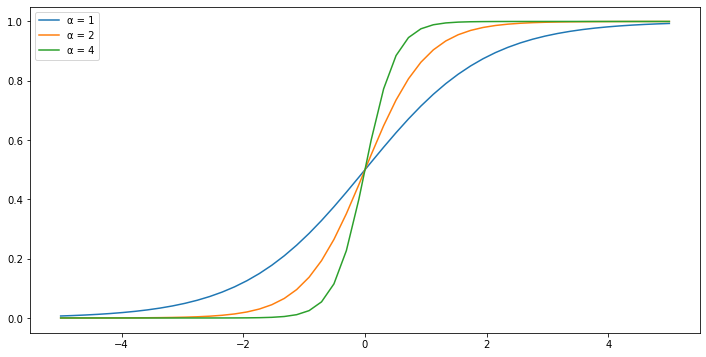

In [3]:
# Vaš kôd ovdje
import math
def sigm(x, alpha = 1.0):
    return 1.0 / (1 + math.e ** (- alpha * x))

X_sigm = np.linspace(-5, 5)
Y_sigm_1a = np.array([sigm(x) for x in X_sigm])
Y_sigm_2a = np.array([sigm(x, 2) for x in X_sigm])
Y_sigm_4a = np.array([sigm(x, 4) for x in X_sigm])

plt.plot(X_sigm, Y_sigm_1a, label="\u03B1 = 1")
plt.plot(X_sigm, Y_sigm_2a, label="\u03B1 = 2")
plt.plot(X_sigm, Y_sigm_4a, label="\u03B1 = 4")
plt.legend()

plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    # Vaš kôd ovdje
    X_exp = np.c_[np.ones(X.shape[0]), X]
    current_iter = 0
    weights = np.zeros(X_exp.shape[1])
    trace_weights=[]
    error = cross_entropy_error(X_exp, y, weights)
    error_diff = error
    while current_iter < max_iter and error_diff > epsilon:
        current_iter += 1
        weight_change = np.zeros(X_exp.shape[1])
        for i in range(0, X_exp.shape[0]):
            h = lr_h(X_exp[i], weights)
            weight_change = weight_change - (h - y[i]) * X_exp[i]
        
        weights[0] = weights[0] + eta * weight_change[0]
        weights[1:] = weights[1:] * (1 - eta * alpha) + eta * weight_change[1:]
        if trace is True:
            trace_weights.append(weights.copy())
        previous_error = error
        error = cross_entropy_error(X_exp, y, weights)
        error_diff = abs(previous_error - error)
    if trace is True:
        return weights, trace_weights
    return weights

def lr_h(x, w):
    return sigm(np.dot(x, w))

def cross_entropy_error(X, y, w):
    total_error = 0.0
    for i in range(0, X.shape[0]):
        total_error += -1 * y[i]* math.log(min(1, lr_h(X[i], w) + 1e-6)) - (1 - y[i]) * math.log(min(1, 1 - lr_h(X[i],w)) + 1e-6)
    return total_error / X.shape[0]

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [5]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

In [6]:
# Vaš kôd ovdje
weights,trace = lr_train(seven_X, seven_y, trace=True)
print("Weights: " + str(weights))
print("Error: " + str(cross_entropy_error(np.c_[np.ones(seven_X.shape[0]),seven_X], seven_y, weights)))

Weights: [ 4.45449454 -1.71089242  0.68413507]
Error: 0.13521757184886535


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [7]:
from sklearn.metrics import zero_one_loss

947


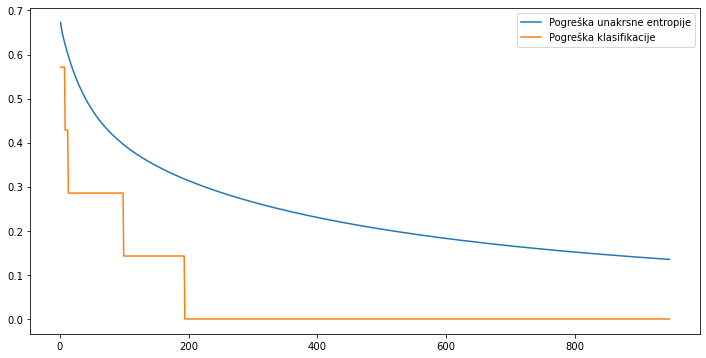

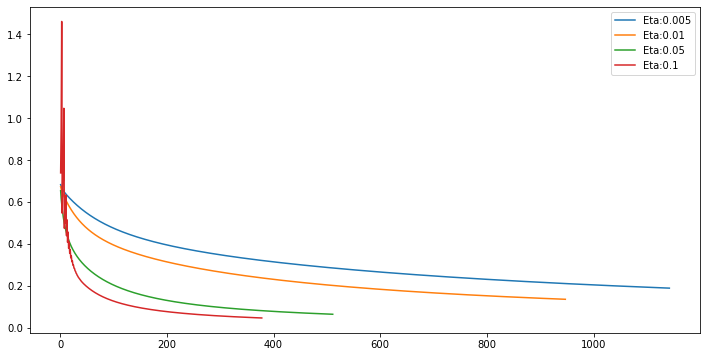

In [8]:
# Vaš kôd ovdje
def zero_one_error(X,y,w):
    total_error = 0.0
    for i in range(0, X.shape[0]):
        step = 0
        if lr_h(X[i],w) > 0.5:
            step = 1
        total_error += (y[i] - step)
    return total_error / X.shape[0]

iterations = range(1, len(trace) + 1)
print(len(trace))
errors_seven = [cross_entropy_error(np.c_[np.ones(seven_X.shape[0]),seven_X], seven_y, trace[i]) for i in range(0, len(trace))]
errors_seven_zo = [zero_one_error(np.c_[np.ones(seven_X.shape[0]),seven_X], seven_y, trace[i]) for i in range(0, len(trace))]
plt.plot(iterations,errors_seven, label="Pogreška unakrsne entropije")
plt.plot(iterations,errors_seven_zo, label="Pogreška klasifikacije")
plt.legend()
plt.show()

for eta in [0.005, 0.01, 0.05, 0.1]:
    weights,trace = lr_train(seven_X, seven_y, eta, trace=True)
    iterations = range(1, len(trace) + 1)
    errors_seven = [cross_entropy_error(np.c_[np.ones(seven_X.shape[0]),seven_X], seven_y, trace[i]) for i in range(0, len(trace))]
    plt.plot(iterations, errors_seven, label="Eta:" + str(eta))
plt.legend()
plt.show()
    


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

In [9]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje
clf = LogisticRegression(random_state=0, penalty="none", max_iter=2000).fit(seven_X, seven_y)
pred_results = clf.predict(seven_X)
weights_clf = np.array([clf.intercept_[0], clf.coef_[0,0], clf.coef_[0,1]])
print("Weights: " + str(weights))
print("Error: " + str(cross_entropy_error(np.c_[np.ones(seven_X.shape[0]),seven_X], seven_y,weights_clf)))

Weights: [ 8.3737975  -2.52497758  0.43304642]
Error: 7.563693030510564e-06


### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [10]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

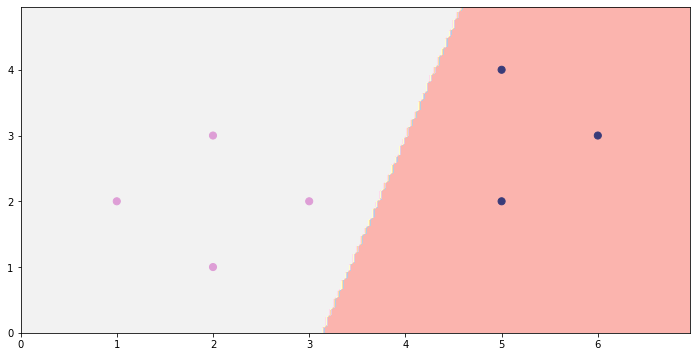

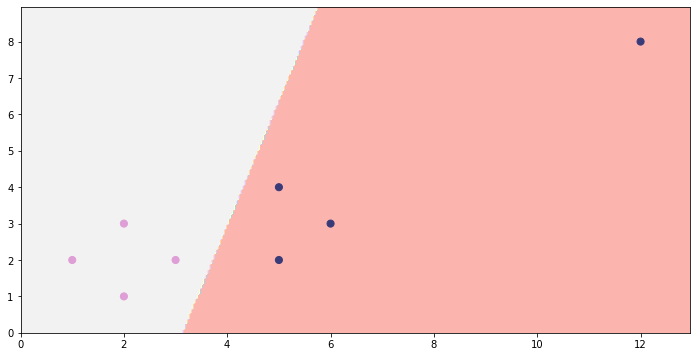

Predictions for first:[1 1 1 1 0 0 0 0]
[1 1 1 1 0 0 0 0]


In [19]:
# Vaš kôd ovdje
clf1 = LogisticRegression(random_state = 0, penalty='none', max_iter= 2000).fit(seven_X, seven_y)
clf2 = LogisticRegression(random_state = 0, penalty='none', max_iter= 2000).fit(outlier_X, outlier_y)

pred_results1 = clf1.predict(outlier_X)
pred_results2 = clf2.predict(outlier_X)

plot_2d_clf_problem(seven_X, seven_y, clf.predict)
plt.show()
plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)
plt.show()
print("Predictions for first:" + str(pred_results2))
print(pred_results1)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

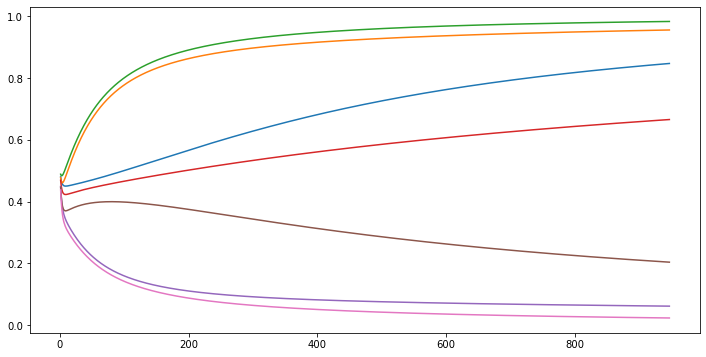

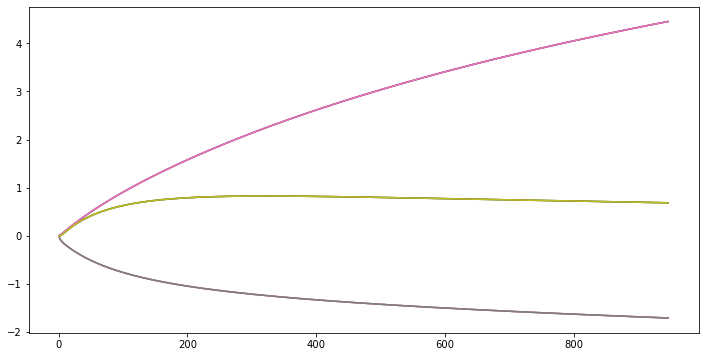

In [20]:
# Vaš kôd ovdje
weights, trace = lr_train(seven_X, seven_y, trace=True)

iterations = range(1, len(trace) + 1)
output_values = []
for i in range(0, seven_X.shape[0]):
    output_values.append([lr_h(np.r_[np.ones(1), seven_X[i]], trace[j]) for j in range(0, len(trace))])
for values in output_values:
    plt.plot(iterations,values)
plt.show()


weights_axis = [[],[],[]]
for i in range(0, len(trace)):
    for j in range(0, 3):
        weights_axis[j].append(trace[i])

for i in range(0, len(weights_axis)):
    plt.plot(iterations, weights_axis[i])
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [21]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)


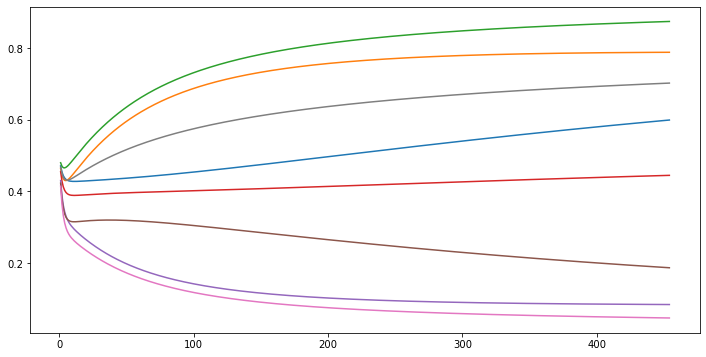

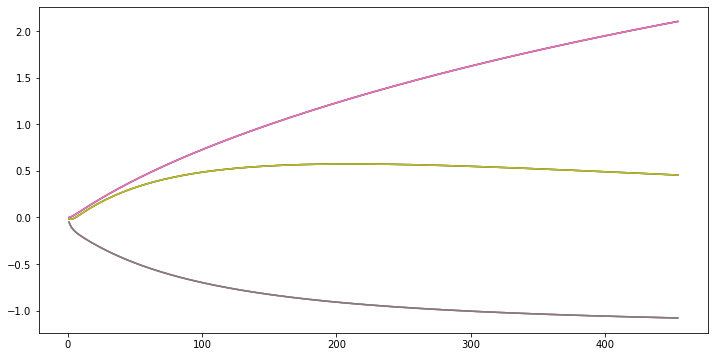

In [22]:
# Vaš kôd ovdje
weights, trace = lr_train(unsep_X, unsep_y, trace=True)

iterations = range(1, len(trace) + 1)
output_values = []
for i in range(0, unsep_X.shape[0]):
    output_values.append([lr_h(np.r_[np.ones(1), unsep_X[i]], trace[j]) for j in range(0, len(trace))])
for values in output_values:
    plt.plot(iterations,values)
plt.show()

weights_axis = [[],[],[]]
for i in range(0, len(trace)):
    for j in range(0, 3):
        weights_axis[j].append(trace[i])

for i in range(0, len(weights_axis)):
    plt.plot(iterations, weights_axis[i])
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [23]:
from numpy.linalg import norm

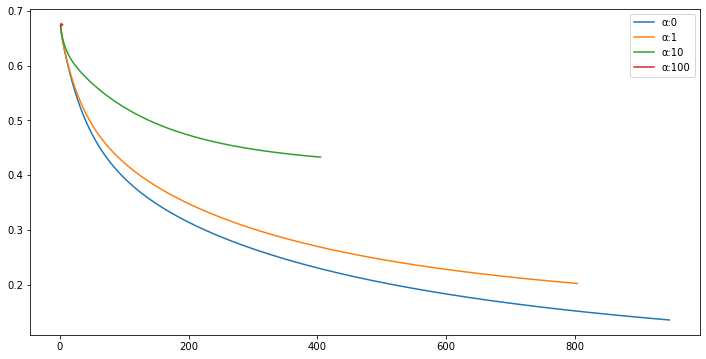

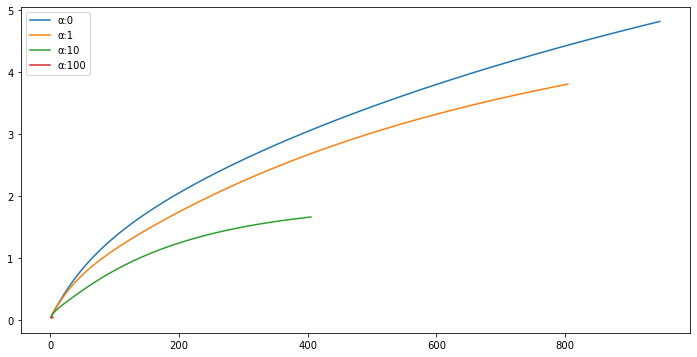

In [28]:
# Vaš kôd ovdje
for alpha in [0, 1, 10, 100]:
    weights, trace = lr_train(seven_X, seven_y, alpha = alpha, trace=True)
    iterations = range(1, len(trace) + 1)
    error = [cross_entropy_error(np.c_[np.ones(seven_X.shape[0]), seven_X], seven_y, trace[i]) for i in range(0, len(trace))]
    plt.plot(iterations,error, label="\u03B1:" + str(alpha))
plt.legend()
plt.show()
for alpha in [0, 1, 10, 100]:
    weights, trace = lr_train(seven_X, seven_y, alpha = alpha, trace=True)
    iterations = range(1, len(trace) + 1)
    norms = [norm(x) for x in trace]
    plt.plot(iterations,norms, label="\u03B1:" + str(alpha))
plt.legend()
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [25]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

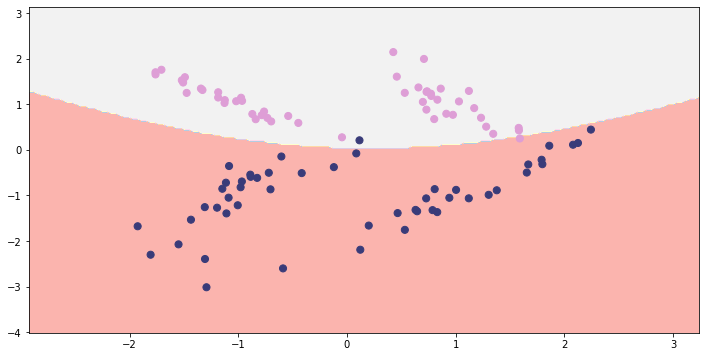

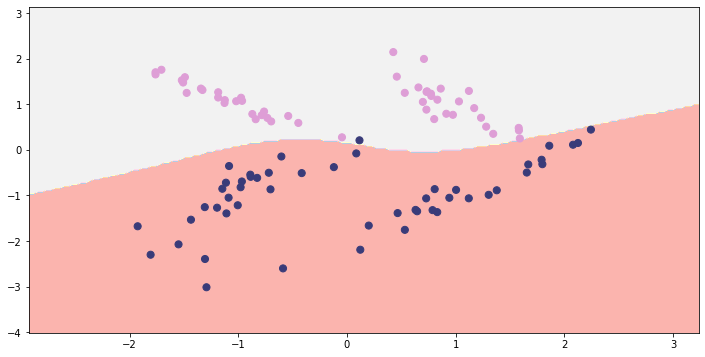

In [26]:
from sklearn.datasets import make_classification

X, y = make_classification(n_clusters_per_class=2, n_classes=2, n_samples=100,n_features=2, n_redundant = 0, n_informative=2)
dX2 = PolynomialFeatures(2).fit_transform(X)
dX3 = PolynomialFeatures(3).fit_transform(X)
clf2 = LogisticRegression().fit(dX2,y)
clf3 = LogisticRegression().fit(dX3, y)
plot_2d_clf_problem(X, y, lambda x: clf2.predict(PolynomialFeatures(2).fit_transform(x)))
plt.show()
plot_2d_clf_problem(X, y, lambda x: clf3.predict(PolynomialFeatures(3).fit_transform(x)))
plt.show()
# Vaš kôd ovdje

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?